In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
import lightgbm as lgb
from tqdm import tqdm

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

In [3]:
tracking1 = pd.read_csv('./data/nfl-big-data-bowl-2021/week1.csv')
tracking2 = pd.read_csv('./data/nfl-big-data-bowl-2021/week2.csv')
tracking3 = pd.read_csv('./data/nfl-big-data-bowl-2021/week3.csv')
tracking4 = pd.read_csv('./data/nfl-big-data-bowl-2021/week4.csv')
tracking5 = pd.read_csv('./data/nfl-big-data-bowl-2021/week5.csv')
tracking6 = pd.read_csv('./data/nfl-big-data-bowl-2021/week6.csv')
tracking7 = pd.read_csv('./data/nfl-big-data-bowl-2021/week7.csv')
tracking8 = pd.read_csv('./data/nfl-big-data-bowl-2021/week8.csv')
tracking9 = pd.read_csv('./data/nfl-big-data-bowl-2021/week9.csv')
tracking10 = pd.read_csv('./data/nfl-big-data-bowl-2021/week10.csv')
tracking11 = pd.read_csv('./data/nfl-big-data-bowl-2021/week11.csv')
tracking12 = pd.read_csv('./data/nfl-big-data-bowl-2021/week12.csv')
tracking13 = pd.read_csv('./data/nfl-big-data-bowl-2021/week13.csv')
tracking14 = pd.read_csv('./data/nfl-big-data-bowl-2021/week14.csv')
tracking15 = pd.read_csv('./data/nfl-big-data-bowl-2021/week15.csv')
tracking16 = pd.read_csv('./data/nfl-big-data-bowl-2021/week16.csv')
tracking17 = pd.read_csv('./data/nfl-big-data-bowl-2021/week17.csv')

df = pd.concat([tracking1,
                      tracking2,
                      tracking3,
                      tracking4,
                      tracking5,
                      tracking6,
                      tracking7,
                      tracking8,
                      tracking9,
                      tracking10,
                      tracking11,
                      tracking12,
                      tracking13,
                      tracking14,
                      tracking15,
                      tracking16,
                      tracking17
                     ], axis=0)

plays = pd.read_csv('./data/nfl-big-data-bowl-2021/plays.csv')

# Process Data

## Get Targeted Receiver

In [4]:
defense_positions = ['SS', 'FS', 'MLB', 'CB', 'LB', 'OLB', 'ILB', 'DL', 'DB', 'NT', 'S', 'DE']
pass_arrived_time = ['pass_arrived', 'pass_outcome_caught', 'pass_outcome_incomplete', 'pass_outcome_interception', 'pass_outcome_touchdown']

In [5]:
pass_arrived = df[df['event'].isin(['pass_arrived', 'pass_outcome_caught', 'pass_outcome_incomplete', 'pass_outcome_interception', 'pass_outcome_touchdown'])]
ball_positions = pass_arrived[pass_arrived['nflId'].isna()][['gameId', 'playId', 'x', 'y']].rename(columns={'x': 'ball_x', 'y': 'ball_y'})
pass_arrived = pass_arrived.merge(ball_positions, on=['gameId', 'playId'], how='left')
pass_arrived['distance_to_ball'] = np.sqrt((pass_arrived['x'] - pass_arrived['ball_x'])**2 + (pass_arrived['y'] - pass_arrived['ball_y'])**2)
pass_arrived = pass_arrived[~pass_arrived['position'].isin(defense_positions)]
pass_arrived = pass_arrived[pass_arrived['nflId'].notna()]
pass_arrived = pass_arrived[pass_arrived['distance_to_ball'].notna()]
target_receiver = pass_arrived.loc[pass_arrived.groupby(['gameId', 'playId'])['distance_to_ball'].idxmin()][['gameId', 'playId', 'nflId', 'distance_to_ball']]
target_receiver = target_receiver.rename(columns={'nflId':'target_receiver_nflId'})
target_receiver = target_receiver.drop('distance_to_ball', axis=1)

## Get Target Reciever Position When Ball Thrown

In [6]:
pass_forward = df[df['event'] == 'pass_forward']
pass_forward = pass_forward.merge(target_receiver, on=['gameId', 'playId'], how='left')

In [7]:
targeted_reciever_positions = pass_forward.groupby(['gameId', 'playId', 'target_receiver_nflId'])[['x', 'y', 's', 'a', 'dis', 'o', 'dir']].mean()

targeted_reciever_positions = targeted_reciever_positions.rename(columns={'x':'targeted_receiver_pass_forward_x', 
                                            'y':'targeted_receiver_pass_forward_y', 
                                            's':'targeted_receiver_pass_forward_s', 
                                            'a':'targeted_receiver_pass_forward_a', 
                                            'dis':'targeted_receiver_pass_forward_dis', 
                                            'o':'targeted_receiver_pass_forward_o', 
                                            'dir':'targeted_receiver_pass_forward_dir'})

targeted_receiver_info = target_receiver.merge(targeted_reciever_positions, 
                      left_on=['gameId', 'playId', 'target_receiver_nflId'], 
                      right_index=True)

## Get Closest Defender

In [8]:
defense_positions_non_line = ['SS', 'FS', 'MLB', 'CB', 'LB', 'OLB', 'ILB', 'DB', 'S']
pass_forward_time = ['pass_forward']

In [9]:
pass_forward = df[df['event'].isin(pass_forward_time)]
pass_forward = pass_forward[pass_forward['position'].isin(defense_positions_non_line)]
pass_forward = pass_forward[pass_forward['nflId'].notna()]
pass_forward = pass_forward.merge(targeted_receiver_info, left_on=['gameId', 'playId'], right_on=['gameId', 'playId'])
pass_forward['closest_defender_distance_from_target_receiver'] = np.sqrt((pass_forward['x'] - pass_forward['targeted_receiver_pass_forward_x'])**2 + (pass_forward['y'] - pass_forward['targeted_receiver_pass_forward_y'])**2)
closest_defenders = pass_forward.loc[pass_forward.groupby(['gameId', 'playId'])['closest_defender_distance_from_target_receiver'].idxmin()][['gameId', 'playId', 'nflId', 'x', 'y', 's', 'a', 'dis', 'o', 'dir', 'closest_defender_distance_from_target_receiver']]


In [10]:
closest_defenders = closest_defenders.rename(columns={
                               'nflId':'closest_defender_nflId',
                               'x':'closest_defender_pass_forward_x',
                               'y':'closest_defender_pass_forward_y',
                               's':'closest_defender_pass_forward_s',
                               'a':'closest_defender_pass_forward_a',
                               'dis':'closest_defender_pass_forward_dis',
                               'o':'closest_defender_pass_forward_o',
                               'dir':'closest_defender_pass_forward_dir'})

In [11]:
data = closest_defenders.merge(targeted_receiver_info, on=['gameId', 'playId'])

## Get Pass Distance

In [12]:
football_pass_forward_positions = df[(df['team'] == 'football') & (df['event'] == 'pass_forward')]
football_pass_forward_positions = football_pass_forward_positions[['gameId', 'playId', 'x', 'y', 's', 'a', 'dis']]
football_pass_forward_positions = football_pass_forward_positions.rename(columns={'x':'football_pass_forward_x', 
                                                'y':'football_pass_forward_y',
                                               's':'football_pass_forward_s',
                                               'a':'football_pass_forward_a',
                                               'dis':'football_pass_forward_dis'})

In [13]:
data = data.merge(football_pass_forward_positions, on=['gameId', 'playId'])
data['targeted_receiver_distance_from_pass_forward'] = np.sqrt((data['football_pass_forward_x'] - data['targeted_receiver_pass_forward_x'])**2 + (data['football_pass_forward_y'] - data['targeted_receiver_pass_forward_y'])**2)
data['closest_defender_distance_from_pass_forward'] = np.sqrt((data['football_pass_forward_x'] - data['closest_defender_pass_forward_x'])**2 + (data['football_pass_forward_y'] - data['closest_defender_pass_forward_y'])**2)








In [14]:
labels = plays.groupby(['gameId', 'playId']).agg('first')['passResult'].reset_index()

# Model Completion Probability

In [15]:
data['closest_defender_distance_from_pass_forward_difference'] = data['targeted_receiver_distance_from_pass_forward'] - data['closest_defender_distance_from_pass_forward']
data['targeted_receiver_pass_forward_o_dir_diff'] = data['targeted_receiver_pass_forward_o'] - data['targeted_receiver_pass_forward_dir']
data['closest_defender_pass_forward_o_dir_diff'] = data['closest_defender_pass_forward_o'] - data['closest_defender_pass_forward_dir']
data['targeted_closest_dir_difference'] = data['closest_defender_pass_forward_dir'] - data['targeted_receiver_pass_forward_dir']
data['targeted_closest_o_difference'] = data['closest_defender_pass_forward_o'] - data['targeted_receiver_pass_forward_o']

In [16]:
data = data.merge(labels, on=['gameId', 'playId'])
data = data[data['passResult'] != 'S']
data['passResult'] = data['passResult'].apply(lambda x: 1 if x == 'C' else 0)
y = data['passResult']
X = data.drop(['gameId', 'playId', 'passResult', 'closest_defender_nflId', 'target_receiver_nflId'], axis=1)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = lgb.LGBMClassifier()

param_grid = {
    'learning_rate': [0.1, 0.05],
    'n_estimators': [100],
    'max_depth': [3],
    'min_child_samples': [30],
    'subsample': [0.8],
    'verbosity': [-1]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='accuracy', cv=5, verbose=1, n_jobs=1)

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_}")


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Accuracy: 0.6648801128349788
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_child_samples': 30, 'n_estimators': 100, 'subsample': 0.8, 'verbosity': -1}
Best Cross-Validation Score: 0.6449886692387867


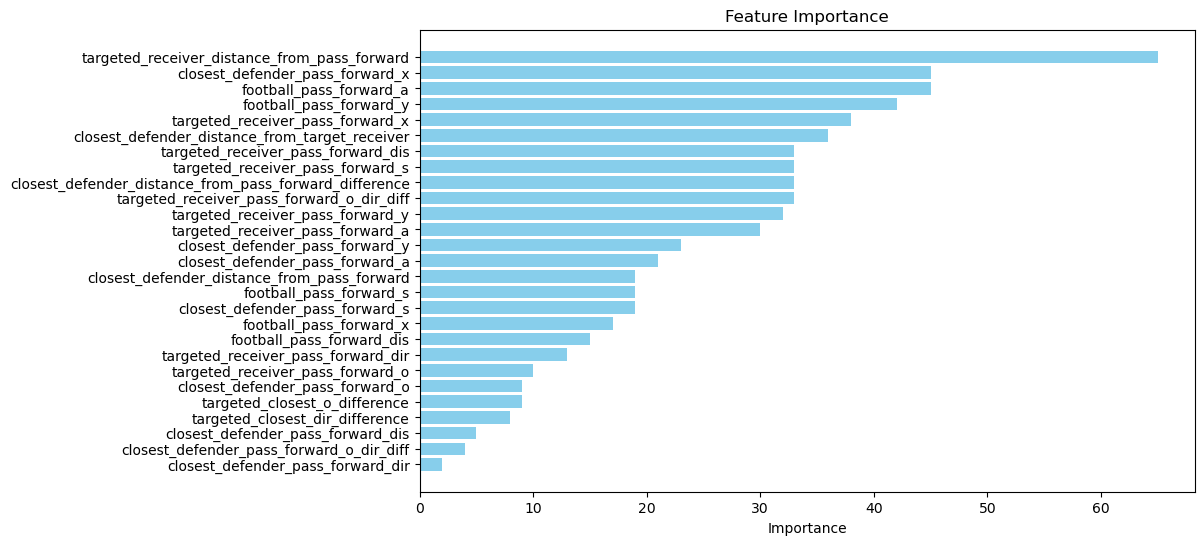

                                              Feature  Importance
20       targeted_receiver_distance_from_pass_forward          65
0                     closest_defender_pass_forward_x          45
18                            football_pass_forward_a          45
16                            football_pass_forward_y          42
8                    targeted_receiver_pass_forward_x          38
7      closest_defender_distance_from_target_receiver          36
12                 targeted_receiver_pass_forward_dis          33
10                   targeted_receiver_pass_forward_s          33
22  closest_defender_distance_from_pass_forward_di...          33
23          targeted_receiver_pass_forward_o_dir_diff          33


In [18]:
best_model = grid_search.best_estimator_
importances = best_model.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

print(feature_importance_df.head(10))


# Apply Model To All Time Frames

In [19]:
df[df['gameId'] == 2018090600]

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route
0,2018-09-07T01:07:14.599Z,91.73,26.67,0.00,0.01,0.02,289.57,240.93,NaN,310.0,Matt Ryan,2.0,QB,1,away,2018090600,75,left,NaN
1,2018-09-07T01:07:14.599Z,88.89,36.47,0.01,0.01,0.01,105.63,66.66,NaN,79848.0,Malcolm Jenkins,27.0,SS,1,home,2018090600,75,left,NaN
2,2018-09-07T01:07:14.599Z,91.35,44.16,0.02,0.03,0.01,290.45,16.86,NaN,2495454.0,Julio Jones,11.0,WR,1,away,2018090600,75,left,HITCH
3,2018-09-07T01:07:14.599Z,86.31,22.01,0.09,0.42,0.01,70.12,168.91,NaN,2495613.0,Corey Graham,24.0,FS,1,home,2018090600,75,left,NaN
4,2018-09-07T01:07:14.599Z,90.78,36.15,0.00,0.00,0.00,257.61,193.97,NaN,2533040.0,Mohamed Sanu,12.0,WR,1,away,2018090600,75,left,HITCH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78989,2018-09-07T04:24:10.900Z,10.68,41.17,0.03,0.45,0.00,156.63,198.20,NaN,2555383.0,Jalen Mills,31.0,CB,55,home,2018090600,4472,left,NaN
78990,2018-09-07T04:24:10.900Z,1.32,24.39,1.26,1.17,0.13,207.52,193.99,NaN,2555415.0,Austin Hooper,81.0,TE,55,away,2018090600,4472,left,GO
78991,2018-09-07T04:24:10.900Z,9.26,8.97,1.35,0.82,0.14,193.35,178.45,NaN,2557958.0,Sidney Jones,22.0,CB,55,home,2018090600,4472,left,NaN
78992,2018-09-07T04:24:10.900Z,16.01,38.77,0.85,0.45,0.08,132.89,110.26,NaN,2560854.0,Calvin Ridley,18.0,WR,55,away,2018090600,4472,left,FLAT


In [42]:
# Specify the gameId, playId, and frameId for testing
# test_game_id = 2018090600  # Replace with the gameId you want to test
# test_play_ids = [75, 4472]  # Replace with the playIds you want to test

# Filter the dataframe for the selected gameId and playIds
# df_test = df[(df['gameId'] == test_game_id) & (df['playId'].isin(test_play_ids))]
# df = tracking1.copy()

weeks = [
          tracking1,
          tracking2,
          tracking3,
          tracking4,
          tracking5,
          tracking6,
          tracking7,
          tracking8,
          tracking9,
          tracking10,
          tracking11,
          tracking12,
          tracking13,
          tracking14,
          tracking15,
          tracking16,
          tracking17
        ]

for i, week in enumerate(weeks):
    
    print(f"week {i+1}")
    df = week.copy()
    # Filter receivers (e.g., WR) and defenders (e.g., CB)
    receivers = df[df['position'].isin(['WR', 'TE'])]
    defenders = df[df['position'].isin(defense_positions_non_line)]
    
    # Initialize a list to store the data for the new dataframe
    data_for_new_df = []
    
    # Iterate through each frameId of the receiver and find the closest defender at each frameId
    for _, receiver in tqdm(receivers.iterrows(), total=receivers.shape[0], desc="Processing receivers"):
        # Filter defenders for the same gameId and playId as the receiver at the same frameId
        defenders_in_frame = defenders[(defenders['gameId'] == receiver['gameId']) & 
                                       (defenders['playId'] == receiver['playId']) & 
                                       (defenders['frameId'] == receiver['frameId'])]

        
        # Calculate the Euclidean distance between the receiver and all defenders at the same frameId
        distances = np.sqrt((defenders_in_frame['x'] - receiver['x'])**2 + (defenders_in_frame['y'] - receiver['y'])**2)

        if len(distances) == 0:
            continue
        
        # Find the index of the closest defender
        closest_defender_idx = distances.idxmin()
        closest_defender = defenders_in_frame.loc[closest_defender_idx]
        
        # Calculate the closest defender distance from the receiver
        closest_defender_distance = distances.min()
        
        # Filter the football position (nflId is NaN) at the same frameId
        football = df[df['nflId'].isna() & (df['frameId'] == receiver['frameId'])]
        
        # Get football position at the same frameId
        if not football.empty:
            football_position = football.iloc[0]
        else:
            football_position = None
        
        # Calculate various distances and differences
        targeted_receiver_distance_from_pass_forward = np.nan  # You can add this calculation based on the football's position
        closest_defender_distance_from_pass_forward = np.nan  # Similarly, add calculation here
        
        # For now, assuming distance calculations between the football and the receiver/defender at pass frameId
        if football_position is not None:
            targeted_receiver_distance_from_pass_forward = np.sqrt(
                (receiver['x'] - football_position['x'])**2 + (receiver['y'] - football_position['y'])**2)
            
            closest_defender_distance_from_pass_forward = np.sqrt(
                (closest_defender['x'] - football_position['x'])**2 + (closest_defender['y'] - football_position['y'])**2)
            
        
        # Add the data to the list
        data_for_new_df.append({
            'gameId':receiver['gameId'],
            'playId':receiver['playId'],
            'frameId':receiver['frameId'],
            'receiver_nflId':receiver['nflId'],
            'closest_defender_nflId':closest_defender['nflId'],
            'closest_defender_pass_forward_x': closest_defender['x'],
            'closest_defender_pass_forward_y': closest_defender['y'],
            'closest_defender_pass_forward_s': closest_defender['s'],
            'closest_defender_pass_forward_a': closest_defender['a'],
            'closest_defender_pass_forward_dis': closest_defender['dis'],
            'closest_defender_pass_forward_o': closest_defender['o'],
            'closest_defender_pass_forward_dir': closest_defender['dir'],
            'closest_defender_distance_from_target_receiver': closest_defender_distance, 
            
            'targeted_receiver_pass_forward_x': receiver['x'],
            'targeted_receiver_pass_forward_y': receiver['y'],
            'targeted_receiver_pass_forward_s': receiver['s'],
            'targeted_receiver_pass_forward_a': receiver['a'],
            'targeted_receiver_pass_forward_dis': receiver['dis'],
            'targeted_receiver_pass_forward_o': receiver['o'],
            'targeted_receiver_pass_forward_dir': receiver['dir'],
            
            'football_pass_forward_x': football_position['x'] if football_position is not None else np.nan,
            'football_pass_forward_y': football_position['y'] if football_position is not None else np.nan,
            'football_pass_forward_s': football_position['s'] if football_position is not None else np.nan,
            'football_pass_forward_a': football_position['a'] if football_position is not None else np.nan,
            'football_pass_forward_dis': football_position['dis'] if football_position is not None else np.nan,
            
            'targeted_receiver_distance_from_pass_forward': targeted_receiver_distance_from_pass_forward,
            'closest_defender_distance_from_pass_forward': closest_defender_distance_from_pass_forward,
            
            'closest_defender_distance_from_pass_forward_difference': targeted_receiver_distance_from_pass_forward - closest_defender_distance_from_pass_forward,
            
            'targeted_receiver_pass_forward_o_dir_diff': receiver['o'] - receiver['dir'],
            'closest_defender_pass_forward_o_dir_diff': closest_defender['o'] - closest_defender['dir'],
            
            'targeted_closest_dir_difference': receiver['dir'] - closest_defender['dir'],
            'targeted_closest_o_difference': receiver['o'] - closest_defender['o']
        })
    
    # Convert the list into a DataFrame
    new_df = pd.DataFrame(data_for_new_df)

    probabilities = grid_search.predict_proba(new_df.iloc[:, 5:])
    probabilities = probabilities[:, 1]

    new_df = new_df.join(pd.Series(probabilities, name='completion_probability'))
    new_df.to_csv(f"./output/completion_probabilities_week{i+1}.csv", index=False)
    

week 3


Processing receivers: 100%|████████████| 312589/312589 [36:10<00:00, 143.99it/s]


week 4


Processing receivers: 100%|████████████| 320737/320737 [37:50<00:00, 141.28it/s]


week 5


Processing receivers: 100%|████████████| 312930/312930 [36:01<00:00, 144.76it/s]


week 6


Processing receivers: 100%|████████████| 287635/287635 [29:59<00:00, 159.87it/s]


week 7


Processing receivers: 100%|████████████| 262074/262074 [26:14<00:00, 166.43it/s]


week 8


Processing receivers: 100%|████████████| 266155/266155 [26:47<00:00, 165.56it/s]


week 9


Processing receivers: 100%|████████████| 253161/253161 [25:40<00:00, 164.29it/s]


week 10


Processing receivers: 100%|████████████| 255400/255400 [25:49<00:00, 164.81it/s]


week 11


Processing receivers: 100%|████████████| 248031/248031 [25:01<00:00, 165.17it/s]


week 12


Processing receivers: 100%|████████████| 271884/271884 [29:03<00:00, 155.94it/s]


week 13


Processing receivers: 100%|████████████| 314128/314128 [36:21<00:00, 144.00it/s]


week 14


Processing receivers: 100%|████████████| 308241/308241 [37:16<00:00, 137.80it/s]


week 15


Processing receivers: 100%|██████████| 287854/287854 [13:38:23<00:00,  5.86it/s]


week 16


Processing receivers: 100%|████████████| 303975/303975 [38:27<00:00, 131.72it/s]


week 17


Processing receivers: 100%|████████████| 276000/276000 [33:37<00:00, 136.81it/s]
